In [20]:
%%time
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd
import re
from bs4 import BeautifulSoup as bs
import nltk
from nltk.corpus import wordnet
from nltk import word_tokenize
import numpy as np
import string
from nltk.corpus import stopwords
import os
import email
from html.parser import HTMLParser
import matplotlib.pyplot as plt
import seaborn as sns

Wall time: 0 ns


Reading in the non-normarlized agg file

In [143]:
df = pd.read_csv('C:/Users/bodie/Documents/emails_not_normalized.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 15 columns):
Unnamed: 0            9353 non-null int64
dir_name              9353 non-null object
is_spam               9353 non-null int64
from                  9351 non-null object
domain                9310 non-null object
domain_type           9353 non-null object
subject               9343 non-null object
subj_char_cnt         9353 non-null int64
subject_all_caps      9353 non-null int64
attachments           9353 non-null int64
urls                  9353 non-null int64
day_of_week           9353 non-null object
full_text_all_caps    9353 non-null int64
full_text_cnt         9353 non-null int64
full_text             9353 non-null object
dtypes: int64(8), object(7)
memory usage: 1.1+ MB


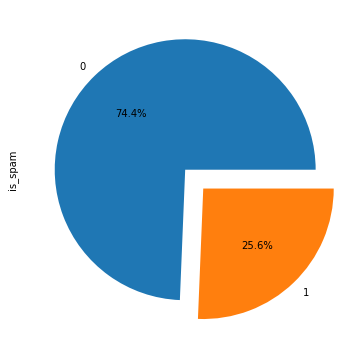

In [144]:
df["is_spam"].value_counts().plot(kind = 'pie', 
                                  explode = [0,0.2], 
                                  figsize= (6,6),
                                  autopct='%1.1f%%')
plt.show()


# Creating Seed and CV object

In [145]:
%%time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold

import random
#Setting Seed
#will use this in CV portion
random.seed(10)
seed = random.randint(1,500)
print("seed is:",seed)


#Creating the  CV
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         random_state = seed,
                         test_size  = 0.2)



print(cv_object)


seed is: 293
ShuffleSplit(n_splits=10, random_state=293, test_size=0.2, train_size=None)
Wall time: 0 ns


# Creating X & Y arrays

In [146]:
%%time
if 'is_spam' in df:
    y = df['is_spam'].values
    del df['is_spam']
    X = df['full_text']

Wall time: 1.99 ms


# Functions from nlp class

In [147]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def build_feature_matrix(documents, feature_type='frequency', 
                         ngram_range=(1, 1), min_df=0.0, max_df=1.0): 
    feature_type = feature_type.lower().strip()   
    if feature_type == 'binary': 
        vectorizer = CountVectorizer(binary=True, min_df=min_df, 
                                     max_df=max_df, ngram_range=ngram_range) 
    elif feature_type == 'frequency': 
        vectorizer = CountVectorizer(binary=False, min_df=min_df, 
                                         max_df=max_df, ngram_range=ngram_range)
    elif feature_type == 'tfidf': 
        vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df, ngram_range=ngram_range) 
    else: 
            raise Exception("Wrong feature type entered. Possible values: 'binary', 'frequency', 'tfidf'") 
            
    feature_matrix = vectorizer.fit_transform(documents).astype(float) 
        
    return vectorizer, feature_matrix


def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

# NB Model

In [148]:
%%time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics as mt
from sklearn.pipeline import Pipeline

##Model
clf = MultinomialNB()



Iteration = []
Accuracy = []
Sensitivity = []
Specificity = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    norm_train_reviews = normalize_corpus(X[train_indices])
    vectorizer, train_features = build_feature_matrix(documents=norm_train_reviews,
                                                  feature_type='tfidf',
                                                  ngram_range=(1, 1), 
                                                  min_df=0.0, max_df=1.0)                                      
                                      
    clf.fit(train_features,y[train_indices]) 
    norm_test_reviews = normalize_corpus(X[test_indices])
    test_features = vectorizer.transform(norm_test_reviews)
    
    y_hat = clf.predict(test_features) # get test set precitions
    
    cm1 = mt.confusion_matrix(y[test_indices],y_hat)
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y[test_indices],y_hat))
    Sensitivity.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    
NB_results = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Sensitivity':Sensitivity,
                                'Specificity':Specificity},columns = ['Iteration','Accuracy','Sensitivity','Specificity'])


NB_results


Wall time: 2min 36s


,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.873864,1.0,0.527054
1,1,0.887226,1.0,0.569388
2,2,0.879743,1.0,0.557957
3,3,0.892036,1.0,0.563715
4,4,0.886157,1.0,0.561728
5,5,0.900053,1.0,0.596983
6,6,0.885623,1.0,0.556936
7,7,0.893640,1.0,0.566449
8,8,0.906467,1.0,0.618736
9,9,0.879209,1.0,0.542510


# SVM

In [149]:
%%time
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss='hinge', max_iter=500)



Iteration = []
Accuracy = []
Sensitivity = []
Specificity = []

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    norm_train_reviews = normalize_corpus(X[train_indices])
    vectorizer, train_features = build_feature_matrix(documents=norm_train_reviews,
                                                  feature_type='tfidf',
                                                  ngram_range=(1, 1), 
                                                  min_df=0.0, max_df=1.0)                                      
                                      
    clf.fit(train_features,y[train_indices]) 
    norm_test_reviews = normalize_corpus(X[test_indices])
    test_features = vectorizer.transform(norm_test_reviews)
    
    y_hat = clf.predict(test_features) # get test set precitions
    
    cm1 = mt.confusion_matrix(y[test_indices],y_hat)
    
    Iteration.append(iter_num)
    Accuracy.append(mt.accuracy_score(y[test_indices],y_hat))
    Sensitivity.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
    Specificity.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
    
SGD_results = pd.DataFrame({'Iteration':Iteration,'Accuracy': Accuracy,'Sensitivity':Sensitivity,
                                'Specificity':Specificity},columns = ['Iteration','Accuracy','Sensitivity','Specificity'])


SGD_results


Wall time: 2min 35s


,Iteration,Accuracy,Sensitivity,Specificity
0,0,0.994121,0.999271,0.979960
1,1,0.997862,0.998552,0.995918
2,2,0.991448,0.994860,0.982318
3,3,0.995724,0.996449,0.993521
4,4,0.992517,0.997112,0.979424
5,5,0.992517,0.995025,0.984914
6,6,0.996259,0.997118,0.993789
7,7,0.991983,0.995042,0.982571
8,8,0.993052,0.996459,0.982571
9,9,0.992517,0.997821,0.977733


# NB ROC Curve

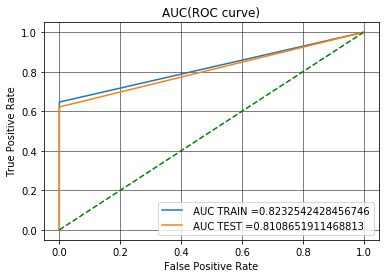

Wall time: 15.7 s


In [161]:
%%time

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

clf = MultinomialNB()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

norm_train_reviews = normalize_corpus(X_train)
                                    

# feature extraction                                                                            
vectorizer, train_features = build_feature_matrix(documents=norm_train_reviews,
                                                  feature_type='tfidf',
                                                  ngram_range=(1, 1), 
                                                  min_df=0.0, max_df=1.0) 

                                                  
clf.fit(train_features, y_train)

# extract features                                     

norm_test_reviews = normalize_corpus(X_test)
test_features = vectorizer.transform(norm_test_reviews)

y_train_pred =clf.predict(train_features)    
y_test_pred = clf.predict(test_features) 


                                                  
###Get curves                                                  
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

# SVM ROC Curve

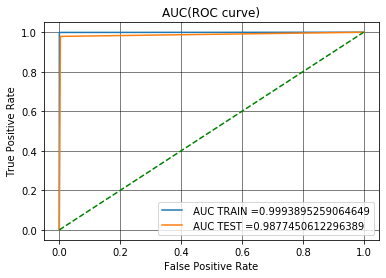

Wall time: 15.4 s


In [160]:
%%time
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

clf = SGDClassifier(loss='hinge', max_iter=500)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20)

norm_train_reviews = normalize_corpus(X_train)
                                    

# feature extraction                                                                            
vectorizer, train_features = build_feature_matrix(documents=norm_train_reviews,
                                                  feature_type='tfidf',
                                                  ngram_range=(1, 1), 
                                                  min_df=0.0, max_df=1.0) 

                                                  
clf.fit(train_features, y_train)

# extract features                                     

norm_test_reviews = normalize_corpus(X_test)
test_features = vectorizer.transform(norm_test_reviews)

y_train_pred =clf.predict(train_features)    
y_test_pred = clf.predict(test_features) 


                                                  
###Get curves                                                  
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.grid()

plt.plot(train_fpr, train_tpr, label=" AUC TRAIN ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()